### CNN classifier

In [1]:
import os

from IPython.display import clear_output

In [2]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/CNN_mimi/")

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import xarray as xr
from matplotlib import cm
from PIL import Image
from torch import nn
from torchvision import transforms
from tqdm import tqdm

#### Auxiliar functions

In [4]:
path_to_video = "/home/projeto_mimi/videos/video2A.avi"

#### Loading and labeling data

In [4]:
from src.video_processing import extract_video_frames, label_frames

In [ ]:
frames = extract_video_frames(path_to_video)

n_frames, H, W, d = frames.shape

In [7]:
# Select 500 random frames
training_frames = np.random.choice(
    np.arange(3000, 6000, dtype=int), size=500, replace=False
)

In [ ]:
labels = []
for i, idx_ in enumerate(training_frames):
    print(f"Frame ({i + 1}/{len(training_frames)})")
    labels += [label_frames(frames, idx_)]
    clear_output(wait=True)
labels = np.asarray(labels)

In [ ]:
training_dataset = xr.DataArray(
    frames[training_frames],
    dims=("frames", "height", "width", "depth"),
    coords={"frames": labels},
)

In [ ]:
plt.figure(figsize=(15, 4))

text = ["No rat", "Rat", "Rai in the box"]

pos = 1
for i in range(3):

    plot_frames = training_dataset.sel(frames=i)[:10]

    for f in range(10):
        plt.subplot(3, 10, pos)
        img = Image.fromarray(plot_frames[f].data)
        plt.imshow(torchvision.transforms.Resize((300, 300))(img))
        plt.xticks([])
        plt.yticks([])
        if f == 0:
            plt.ylabel(text[i])
        pos = pos + 1

#### Organize training and testing dataset

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from src.utils import apply_transforms

In [6]:
training_dataset = xr.load_dataarray("/home/projeto_mimi/dataset/training_dataset.nc")

In [7]:
# Define transformations
trfs = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.7),
        transforms.GaussianBlur((3, 3), sigma=(1, 2)),
        transforms.ToTensor(),
        transforms.Resize((300, 300)),
    ]
)

In [8]:
# Inputs and labels
X, y = apply_transforms(
    training_dataset, fraction=None, trfs=transforms.Resize((300, 300)), verbose=True
)
# Augment dataset
X_aug, y_aug = apply_transforms(training_dataset, fraction=0.5, trfs=trfs, verbose=True)
# Transpose due to random flip
X_aug = np.transpose(X_aug, (0, 2, 1, 3))

100%|███████████████████████████████████████████████| 250/250 [00:05<00:00, 42.05it/s]


In [9]:
X_aug.shape

(250, 3, 300, 300)

(-0.5, 299.5, 299.5, -0.5)

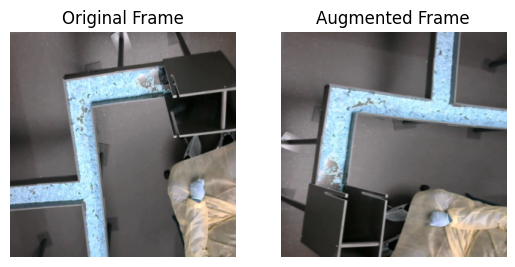

In [10]:
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(X[10], (1, 2, 0)))
plt.title("Original Frame")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Augmented Frame")
plt.imshow(np.transpose(X_aug[10], (1, 2, 0)))
plt.axis("off")

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

In [12]:
X_test.shape

(125, 3, 300, 300)

In [13]:
X_train = np.concatenate((X_train, X_aug), 0)
y_train = np.concatenate((y_train, y_aug), 0)

In [14]:
# Convert to PyTorch tensor
X_train, y_train = torch.Tensor(X_train), torch.Tensor(y_train)
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

In [15]:
trainloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train), batch_size=32
)
testloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_test, y_test), batch_size=32
)

#### CNN class definition

In [16]:
from src.model import CNNclassifer
from src.training import train

In [17]:
cnn = CNNclassifer(
    in_dim=300,
    n_classes=3,
    in_channels=3,
    n_filters=[32, 16, 16, 8],
    n_neurons=[1000, 500, 200],
    kernel_size=[(3, 3)] * 4,
    pool_size=(2, 2),
    dropout=0.2,
)

In [18]:
cnn

CNNclassifer(
  (_conv): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  )
  (_bnorm): ModuleList(
    (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (_linear): ModuleList(
    (0): Linear(in_features=2048, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
    (2): Linear(in_features=500, out_features=200, bias=True)
    (3): Linear(in_features=200, out_features=3, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (activation): ReLU(

In [19]:
train(
    cnn,
    trainloader,
    testloader,
    device="auto",
    epochs=100,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    verbose=True,
)

Using device: cuda


In [20]:
y_prev = (
    (torch.nn.functional.softmax(cnn(X_test.to("cuda")), -1))
    .argmax(-1)
    .to("cpu")
    .detach()
    .numpy()
)

In [21]:
y_test_cpu = y_test.to("cpu").detach().numpy()

In [22]:
accuracy_score(y_prev, y_test_cpu)

0.864

#### Cross Validation Score

In [23]:
from sklearn.model_selection import KFold

In [24]:
def CrossValidationAccuracy(
    cnn,
    X,
    y,
    k=10,
    epochs=100,
    batch_size=128,
    device="auto",
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    verbose=False,
):

    # Creating data folds
    kf = KFold(n_splits=k, shuffle=True)
    kf.get_n_splits(X)

    cv_acc = []
    cv_loss = []
    cv_acc_train = []
    cv_loss_train = []

    pbar = tqdm(kf.split(X)) if verbose else kf.split(X)
    fold = 1
    for train_index, test_index in pbar:

        pbar.set_description(f"Training in fold {fold}/{k}")

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train, y_train = torch.Tensor(X_train), torch.Tensor(y_train)
        X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

        trainloader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size
        )
        testloader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(X_test, y_test), batch_size=batch_size
        )

        out = train(
            cnn,
            trainloader,
            testloader,
            device=device,
            epochs=epochs,
            criterion=criterion,
            optimizer=optimizer,
            verbose=verbose,
            return_scores=True,
            return_train_scores=True,
        )

        cv_loss_train += [out[0]]
        cv_acc_train += [out[1]]
        cv_loss += [out[2]]
        cv_acc += [out[3]]

        fold = fold + 1

    df = pd.DataFrame(
        np.stack((cv_loss_train, cv_acc_train, cv_loss, cv_acc), -1),
        columns=["loss_train", "acc_train", "loss_test", "acc_test"],
    )
    df.index.name = "fold"

    return df

In [26]:
acc = CrossValidationAccuracy(
    cnn, X_train, y_train, k=5, epochs=100, batch_size=32, device="auto", verbose=True
)

Training in fold 1/5: : 0it [00:00, ?it/s]

Using device: cuda


Training in fold 2/5: : 1it [01:10, 70.32s/it]

Using device: cudaoss 0.00000 | acc. train 1.000 | val. loss 3.29471 | acc. val 0.934


Training in fold 3/5: : 2it [02:19, 69.39s/it]

Using device: cudaoss 0.04665 | acc. train 0.987 | val. loss 2.37575 | acc. val 0.887


Training in fold 4/5: : 3it [03:29, 69.67s/it]

Using device: cudaoss 0.00000 | acc. train 1.000 | val. loss 0.76358 | acc. val 0.942


Training in fold 5/5: : 4it [04:38, 69.74s/it]

Using device: cudaoss 0.00000 | acc. train 1.000 | val. loss 2.42749 | acc. val 0.952


Training in fold 5/5: : 5it [05:47, 69.59s/it]

In [32]:
median = acc["acc_test"].median()
sigma = acc["acc_test"].std()
print(f"{median:.3f} +- {sigma:.3f}")

0.934 +- 0.036


In [25]:
# Inputs and labels
X, y = apply_transforms(
    training_dataset, fraction=None, trfs=transforms.Resize((300, 300)), verbose=True
)
# Augment dataset
X_aug, y_aug = apply_transforms(training_dataset, fraction=0.5, trfs=trfs, verbose=True)
# Transpose due to random flip
X_aug = np.transpose(X_aug, (0, 2, 1, 3))

X_train = np.concatenate((X_train, X_aug), 0)
y_train = np.concatenate((y_train, y_aug), 0)

100%|██████████████████████████████████████████████████████| 250/250 [00:04<00:00, 55.37it/s]


In [39]:
cnn_1_nodrop = CNNclassifer(
    in_dim=300,
    n_classes=3,
    in_channels=3,
    n_filters=[32, 16],
    n_neurons=[1000, 200],
    kernel_size=[(3, 3), (3, 3)],
    pool_size=(2, 2),
    dropout=0.0,
)

cnn_1 = CNNclassifer(
    in_dim=300,
    n_classes=3,
    in_channels=3,
    n_filters=[32, 16],
    n_neurons=[1000, 200],
    kernel_size=[(3, 3), (3, 3)],
    pool_size=(2, 2),
    dropout=0.2,
)

In [40]:
cv_cnn_1 = CrossValidationAccuracy(
    cnn_1, X_train, y_train, k=5, epochs=100, batch_size=32, device="auto", verbose=True
)

cv_cnn_1_nodrop = CrossValidationAccuracy(
    cnn_1_nodrop,
    X_train,
    y_train,
    k=5,
    epochs=100,
    batch_size=32,
    device="auto",
    verbose=True,
)

Training in fold 1/5: : 0it [00:00, ?it/s]

Using device: cuda


Training in fold 2/5: : 1it [02:07, 127.05s/it]

Using device: cudaoss 0.00593 | acc. train 0.997 | val. loss 6.17516 | acc. val 0.825


Training in fold 3/5: : 2it [04:13, 126.91s/it]

Using device: cudaoss 0.00993 | acc. train 0.997 | val. loss 409.94296 | acc. val 0.566


Training in fold 4/5: : 3it [06:20, 126.88s/it]

Using device: cudaoss 0.01379 | acc. train 0.993 | val. loss 8.71254 | acc. val 0.776


Training in fold 5/5: : 4it [08:27, 126.86s/it]

Using device: cudaoss 0.00653 | acc. train 0.997 | val. loss 33.48238 | acc. val 0.948


Training in fold 5/5: : 5it [10:34, 126.95s/it]


Training in fold 1/5: : 0it [00:00, ?it/s]

Using device: cuda


Training in fold 2/5: : 1it [02:07, 127.35s/it]

Using device: cudaoss 0.12919 | acc. train 0.962 | val. loss 3.64869 | acc. val 0.826


Training in fold 3/5: : 2it [04:14, 127.14s/it]

Using device: cudaoss 0.02951 | acc. train 0.994 | val. loss 67.81153 | acc. val 0.819


Training in fold 4/5: : 3it [06:21, 127.01s/it]

Using device: cudaoss 0.03091 | acc. train 0.989 | val. loss 7.68918 | acc. val 0.862


Training in fold 5/5: : 4it [08:28, 126.95s/it]

Using device: cudaoss 0.03430 | acc. train 0.983 | val. loss 19.03691 | acc. val 0.873


Training in fold 5/5: : 5it [10:34, 126.99s/it]

In [41]:
cnn_2 = CNNclassifer(
    in_dim=300,
    n_classes=3,
    in_channels=3,
    n_filters=[32, 16, 16, 8],
    n_neurons=[1000, 500, 500, 200],
    kernel_size=[(3, 3)] * 4,
    pool_size=(2, 2),
    dropout=0.2,
)


cnn_2_nodrop = CNNclassifer(
    in_dim=300,
    n_classes=3,
    in_channels=3,
    n_filters=[32, 16, 16, 8],
    n_neurons=[1000, 500, 500, 200],
    kernel_size=[(3, 3)] * 4,
    pool_size=(2, 2),
    dropout=0.0,
)

In [42]:
cv_cnn_2 = CrossValidationAccuracy(
    cnn_2, X_train, y_train, k=5, epochs=100, batch_size=32, device="auto", verbose=True
)

cv_cnn_2_nodrop = CrossValidationAccuracy(
    cnn_2_nodrop,
    X_train,
    y_train,
    k=5,
    epochs=100,
    batch_size=32,
    device="auto",
    verbose=True,
)

Training in fold 1/5: : 0it [00:00, ?it/s]

Using device: cuda


Training in fold 2/5: : 1it [01:36, 96.79s/it]

Using device: cudaoss 0.00396 | acc. train 0.999 | val. loss 1.07610 | acc. val 0.905


Training in fold 3/5: : 2it [03:13, 96.66s/it]

Using device: cudaoss 0.05359 | acc. train 0.986 | val. loss 0.69063 | acc. val 0.900


Training in fold 4/5: : 3it [04:50, 96.72s/it]

Using device: cudaoss 0.00855 | acc. train 0.996 | val. loss 4.99708 | acc. val 0.943


Training in fold 5/5: : 4it [06:26, 96.73s/it]

Using device: cudaoss 0.02775 | acc. train 0.994 | val. loss 0.58465 | acc. val 0.969


Training in fold 5/5: : 5it [08:03, 96.64s/it]


Training in fold 1/5: : 0it [00:00, ?it/s]

Using device: cuda


Training in fold 2/5: : 1it [01:36, 96.62s/it]

Using device: cudaoss 0.00001 | acc. train 1.000 | val. loss 2.17896 | acc. val 0.943


Training in fold 3/5: : 2it [03:13, 96.60s/it]

Using device: cudaoss 0.00027 | acc. train 1.000 | val. loss 18.59546 | acc. val 0.915


Training in fold 4/5: : 3it [04:49, 96.64s/it]

Using device: cudaoss 0.00421 | acc. train 0.999 | val. loss 5.50157 | acc. val 0.926


Training in fold 5/5: : 4it [06:26, 96.61s/it]

Using device: cudaoss 0.01375 | acc. train 0.996 | val. loss 4.52782 | acc. val 0.942


Training in fold 5/5: : 5it [08:03, 96.64s/it]

In [43]:
cnn_1

CNNclassifer(
  (_conv): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  )
  (_bnorm): ModuleList(
    (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (_linear): ModuleList(
    (0): Linear(in_features=85264, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=3, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (activation): ReLU()
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (out): Sigmoid()
)

In [44]:
cnn_2

CNNclassifer(
  (_conv): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  )
  (_bnorm): ModuleList(
    (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (_linear): ModuleList(
    (0): Linear(in_features=2048, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): Linear(in_features=500, out_features=200, bias=True)
    (4): Linear(in_features=200, out_features=3, bias=True)
  )
  

In [45]:
cv_cnn_1["model"] = "cnn1"
cv_cnn_1["drop"] = 1
cv_cnn_1_nodrop["model"] = "cnn1_nodrop"
cv_cnn_1_nodrop["drop"] = 0
cv_cnn_2["model"] = "cnn2"
cv_cnn_2["drop"] = 1
cv_cnn_2_nodrop["model"] = "cnn2_nodrop"
cv_cnn_2_nodrop["drop"] = 0
cv_scores = pd.concat([cv_cnn_1, cv_cnn_1_nodrop, cv_cnn_2, cv_cnn_2_nodrop])

In [46]:
cv_scores

,loss_train,acc_train,loss_test,acc_test,model,drop
fold,,,,,,
0,0.005930,0.997159,6.175159,0.825347,cnn1,1
1,0.009932,0.997159,409.942958,0.565625,cnn1,1
2,0.013785,0.992898,8.712545,0.776389,cnn1,1
3,0.006535,0.997159,33.482383,0.947917,cnn1,1
4,0.001010,1.000000,8.623382,0.925694,cnn1,1
0,0.129193,0.961648,3.648687,0.826042,cnn1_nodrop,0
1,0.029509,0.994318,67.811535,0.819444,cnn1_nodrop,0
2,0.030911,0.988636,7.689181,0.862500,cnn1_nodrop,0
3,0.034298,0.982752,19.036914,0.872917,cnn1_nodrop,0


In [47]:
import seaborn as sns
from scipy.stats import mannwhitneyu

In [48]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"


def add_stats_annot(pval, x1, x2, y, h, col):
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
    plt.text(
        (x1 + x2) * 0.5,
        y + h,
        convert_pvalue_to_asterisks(pval),
        ha="center",
        va="bottom",
        color=col,
    )


def mwhitney(x, y, boot=1000):
    _, p = mannwhitneyu(
        np.random.choice(x, size=boot),
        np.random.choice(y, size=boot),
        alternative="greater",
    )
    return p

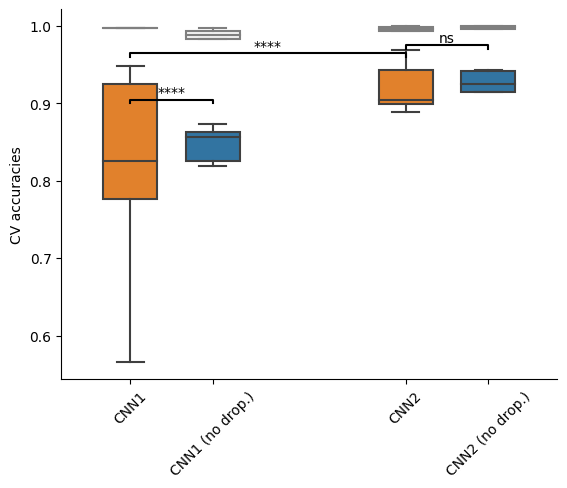

In [52]:
ax = plt.subplot(111)
sns.boxplot(data=cv_scores, x="model", y="acc_test", hue="drop", showfliers=False)
sns.boxplot(
    data=cv_scores,
    x="model",
    y="acc_train",
    hue="drop",
    showfliers=False,
    color="lightgray",
)

add_stats_annot(
    mwhitney(
        cv_scores.loc[cv_scores.model == "cnn1_nodrop"].acc_test,
        cv_scores.loc[cv_scores.model == "cnn1"].acc_test,
    ),
    0.2,
    0.8,
    0.9,
    0.005,
    "k",
)

add_stats_annot(
    mwhitney(
        cv_scores.loc[cv_scores.model == "cnn2"].acc_test,
        cv_scores.loc[cv_scores.model == "cnn2_nodrop"].acc_test,
    ),
    2.2,
    2.8,
    0.97,
    0.005,
    "k",
)

add_stats_annot(
    mwhitney(
        cv_scores.loc[cv_scores.model == "cnn2"].acc_test,
        cv_scores.loc[cv_scores.model == "cnn1"].acc_test,
    ),
    0.2,
    2.2,
    0.96,
    0.005,
    "k",
)

ax.legend().remove()
[ax.spines[pos].set_visible(False) for pos in ["top", "right"]]


plt.xticks(
    [0.2, 0.8, 2.2, 2.8],
    ["CNN1", "CNN1 (no drop.)", "CNN2", "CNN2 (no drop.)"],
    rotation=45,
)
plt.ylabel("CV accuracies")
plt.xlabel("")
plt.savefig("figures/cv_acc.png", bbox_inches="tight", transparent=True, dpi=600)

In [53]:
torch.save(cnn_2, "cnn_2")

#### Classify video

In [4]:
import cv2

from src.utils import apply_transforms
from src.video_processing import extract_video_frames

In [5]:
path_to_video = "/home/projeto_mimi/videos/video2B.avi"

frames = extract_video_frames(path_to_video)

_, H, W, d = frames.shape

In [6]:
frames = xr.DataArray(frames, dims=("frames", "W", "H", "d")).isel(
    frames=slice(4000, 6000)
)

n_frames = len(frames)

In [7]:
frames, _ = apply_transforms(
    frames, fraction=None, trfs=transforms.Resize((300, 300)), verbose=True
)

100%|██████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 397.80it/s]


In [8]:
frames = torch.Tensor(frames)

In [9]:
model = torch.load("cnn_2")
model.eval().to("cuda")

CNNclassifer(
  (_conv): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  )
  (_bnorm): ModuleList(
    (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (_linear): ModuleList(
    (0): Linear(in_features=2048, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): Linear(in_features=500, out_features=200, bias=True)
    (4): Linear(in_features=200, out_features=3, bias=True)
  )
  

In [10]:
labels = np.empty(n_frames)
for i in tqdm(range(n_frames)):
    out = model(frames[i, ...][None, ...].to("cuda"))
    labels[i] = torch.nn.functional.softmax(out.to("cpu"), dim=-1).argmax(-1)

100%|██████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 827.63it/s]


In [11]:
labels = labels.astype(int)

In [12]:
frames = frames.to("cpu").detach().numpy()

In [13]:
for i in range(n_frames):
    img = np.transpose(frames[i], (1, 2, 0))
    if labels[i] == 1:
        frame = cv2.copyMakeBorder(
            img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[255, 0, 0]
        )
    elif labels[i] == 2:
        frame = cv2.copyMakeBorder(
            img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[0, 255, 0]
        )
    elif labels[i] == 0:
        frame = cv2.copyMakeBorder(
            img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[0, 0, 255]
        )
    cv2.imwrite(f"labeled_frames/frame_{labels[i]}_{i}.jpg", frame)